#### **SRILEKHA SOMANCHI**
#### **AM.EN.U4CSE19254**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

import torch
import torchvision
from  torchvision.datasets import ImageFolder 
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.optim as optim
from copy import deepcopy

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


### Dataset, Transforms and Visualization

In [ ]:
transform = transforms.Compose([
      transforms.ToTensor(),
      transforms.Normalize((0.5,0.5,0.5), (0.5, 0.5, 0.5)),
])

train_set = ImageFolder('/content/drive/MyDrive/SportClassification/archive/train', transform = transform)
test_set = ImageFolder('/content/drive/MyDrive/SportClassification/archive/test', transform = transform)
valid_set = ImageFolder('/content/drive/MyDrive/SportClassification/archive/valid', transform = transform)

In [ ]:
print(len(train_set), len(test_set), len(valid_set))

10436 365 375


In [ ]:
num_classes = 73

In [ ]:
batch_size = 4

In [ ]:
trainloader = DataLoader(train_set, batch_size = batch_size, shuffle =  True)
valloader = DataLoader(valid_set, batch_size = batch_size, shuffle = True)
testloader = DataLoader(test_set, batch_size = batch_size, shuffle = False)

In [ ]:
dataiter = iter(trainloader)
images, labels = dataiter.next()

print(images.shape)

print(images[1].shape)
print(labels[1].item())

torch.Size([4, 3, 224, 224])
torch.Size([3, 224, 224])
20


In [ ]:
def imshow(img, title):
    npimg = img.numpy() / 2 + 0.5
    plt.figure(figsize=(batch_size, 1))
    plt.axis('off')
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.title(title)
    plt.show()

In [ ]:
def show_batch_images(dataloader):
    images, labels = next(iter(dataloader))
    img = torchvision.utils.make_grid(images)
    imshow(img, title=[str(x.item()) for x in labels])

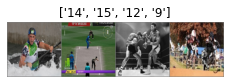

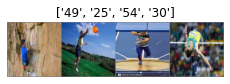

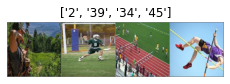

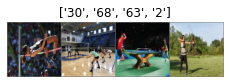

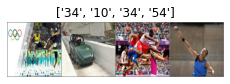

In [ ]:
for i in range(5):
    show_batch_images(trainloader)

In [ ]:
from torchvision import models

In [ ]:
!pip install efficientnet_pytorch

  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16446 sha256=870b020dc9e966c5af622b102574006eec8ea94308688fab044a8e975a93cc8f
  Stored in directory: /root/.cache/pip/wheels/0e/cc/b2/49e74588263573ff778da58cc99b9c6349b496636a7e165be6
Successfully built efficientnet-pytorch


### EfficientNet-B5 (batch size = 4, epochs = 5, SGD - to compute loss)

In [ ]:
from efficientnet_pytorch import EfficientNet
model = EfficientNet.from_pretrained('efficientnet-b5')

Loaded pretrained weights for efficientnet-b5


In [ ]:
#print(model)

In [ ]:
for param in model.parameters():
    param.required_grad = False

In [ ]:
in_features = model._fc.in_features
model._fc = nn.Linear(in_features, num_classes)

In [ ]:
for param in model.parameters():
    if param.requires_grad:
        print(param.shape)

torch.Size([48, 3, 3, 3])
torch.Size([48])
torch.Size([48])
torch.Size([48, 1, 3, 3])
torch.Size([48])
torch.Size([48])
torch.Size([12, 48, 1, 1])
torch.Size([12])
torch.Size([48, 12, 1, 1])
torch.Size([48])
torch.Size([24, 48, 1, 1])
torch.Size([24])
torch.Size([24])
torch.Size([24, 1, 3, 3])
torch.Size([24])
torch.Size([24])
torch.Size([6, 24, 1, 1])
torch.Size([6])
torch.Size([24, 6, 1, 1])
torch.Size([24])
torch.Size([24, 24, 1, 1])
torch.Size([24])
torch.Size([24])
torch.Size([24, 1, 3, 3])
torch.Size([24])
torch.Size([24])
torch.Size([6, 24, 1, 1])
torch.Size([6])
torch.Size([24, 6, 1, 1])
torch.Size([24])
torch.Size([24, 24, 1, 1])
torch.Size([24])
torch.Size([24])
torch.Size([144, 24, 1, 1])
torch.Size([144])
torch.Size([144])
torch.Size([144, 1, 3, 3])
torch.Size([144])
torch.Size([144])
torch.Size([6, 144, 1, 1])
torch.Size([6])
torch.Size([144, 6, 1, 1])
torch.Size([144])
torch.Size([40, 144, 1, 1])
torch.Size([40])
torch.Size([40])
torch.Size([240, 40, 1, 1])
torch.Size([24

In [ ]:
model = model.to(device)
loss_fn = nn.CrossEntropyLoss()
opt = optim.SGD(model.parameters(), lr = 0.01)

In [ ]:
def evaluation(dataloader, model):
    total, correct = 0, 0
    for data in dataloader:
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, pred = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (pred == labels).sum().item()
    return 100 * correct / total

In [ ]:
loss_epoch_arr = []
max_epochs = 5

min_loss = 1000000

n_iters = np.ceil(10436/batch_size) * max_epochs

for epoch in range(max_epochs):

    for i, data in enumerate(trainloader, 0):

        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        opt.zero_grad()

        outputs = model(inputs)
        loss = loss_fn(outputs, labels)
        loss.backward()
        opt.step()
        
        if min_loss > loss.item():
            min_loss = loss.item()
            best_model = deepcopy(model.state_dict())
            print('Iteration: %d/%d, Min loss %0.2f' % (i,n_iters,min_loss))
        
        if i % 100 == 0:
          print('Iteration: %d/%d, Loss: %0.2f, Validation acc: %0.2f'%(i,n_iters, loss.item(), evaluation(valloader, model)))
        
        del inputs, labels, outputs
        torch.cuda.empty_cache()
    loss_epoch_arr.append(loss.item())
    print('Epoch: %d/%d, Validation acc: %0.2f, Train acc: %0.2f' % (
      epoch, max_epochs, 
      evaluation(valloader, model), 
      evaluation(trainloader, model)))

Iteration: 0/327, Min loss 4.14
Iteration: 0/327, Loss: 4.14, Validation acc: 18.67
Iteration: 1/327, Min loss 3.73
Iteration: 2/327, Min loss 3.66
Iteration: 6/327, Min loss 3.57
Iteration: 15/327, Min loss 3.54
Iteration: 16/327, Min loss 3.52
Iteration: 56/327, Min loss 3.49
Iteration: 100/327, Loss: 3.90, Validation acc: 23.47
Iteration: 102/327, Min loss 3.48
Iteration: 120/327, Min loss 3.33
Iteration: 149/327, Min loss 3.31
Iteration: 156/327, Min loss 3.22
Iteration: 174/327, Min loss 3.09
Iteration: 200/327, Loss: 3.91, Validation acc: 22.67
Iteration: 219/327, Min loss 3.08
Iteration: 261/327, Min loss 2.97
Iteration: 292/327, Min loss 2.64
Iteration: 300/327, Loss: 3.81, Validation acc: 25.33
Iteration: 400/327, Loss: 3.43, Validation acc: 26.13
Iteration: 477/327, Min loss 2.45
Iteration: 487/327, Min loss 2.41
Iteration: 500/327, Loss: 2.82, Validation acc: 28.80
Iteration: 505/327, Min loss 2.26
Iteration: 600/327, Loss: 3.85, Validation acc: 36.53
Iteration: 665/327, Min

#### EfficientNet-B5 (Batch size = 8, Epochs = 4, Adam - to compute loss)

In [ ]:
batch_size = 8
num_classes = 73

In [ ]:
trainloader = DataLoader(train_set, batch_size = batch_size, shuffle =  True)
valloader = DataLoader(valid_set, batch_size = batch_size, shuffle = True)
testloader = DataLoader(test_set, batch_size = batch_size, shuffle = False)

In [ ]:
dataiter = iter(trainloader)
images, labels = dataiter.next()

print(images.shape)

print(images[1].shape)
print(labels[1].item())

torch.Size([8, 3, 224, 224])
torch.Size([3, 224, 224])
69


In [ ]:
def imshow(img, title):
    npimg = img.numpy() / 2 + 0.5
    plt.figure(figsize=(batch_size, 1))
    plt.axis('off')
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.title(title)
    plt.show()

In [ ]:
def show_batch_images(dataloader):
    images, labels = next(iter(dataloader))
    img = torchvision.utils.make_grid(images)
    imshow(img, title=[str(x.item()) for x in labels])

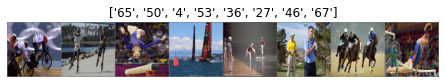

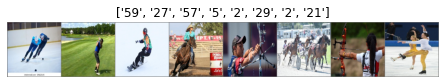

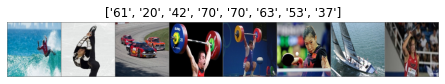

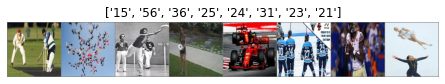

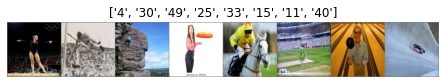

In [ ]:
for i in range(5):
    show_batch_images(trainloader)

In [ ]:
def evaluation(dataloader, model):
    total, correct = 0, 0
    for data in dataloader:
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, pred = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (pred == labels).sum().item()
    return 100 * correct / total

In [ ]:
from efficientnet_pytorch import EfficientNet
model = EfficientNet.from_pretrained('efficientnet-b5')

Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b5-b6417697.pth" to /root/.cache/torch/hub/checkpoints/efficientnet-b5-b6417697.pth


  0%|          | 0.00/117M [00:00<?, ?B/s]

Loaded pretrained weights for efficientnet-b5


In [ ]:
for param in model.parameters():
    param.required_grad = False

In [ ]:
in_features = model._fc.in_features
model._fc = nn.Linear(in_features, num_classes)

In [ ]:
for param in model.parameters():
    if param.requires_grad:
        print(param.shape)

torch.Size([48, 3, 3, 3])
torch.Size([48])
torch.Size([48])
torch.Size([48, 1, 3, 3])
torch.Size([48])
torch.Size([48])
torch.Size([12, 48, 1, 1])
torch.Size([12])
torch.Size([48, 12, 1, 1])
torch.Size([48])
torch.Size([24, 48, 1, 1])
torch.Size([24])
torch.Size([24])
torch.Size([24, 1, 3, 3])
torch.Size([24])
torch.Size([24])
torch.Size([6, 24, 1, 1])
torch.Size([6])
torch.Size([24, 6, 1, 1])
torch.Size([24])
torch.Size([24, 24, 1, 1])
torch.Size([24])
torch.Size([24])
torch.Size([24, 1, 3, 3])
torch.Size([24])
torch.Size([24])
torch.Size([6, 24, 1, 1])
torch.Size([6])
torch.Size([24, 6, 1, 1])
torch.Size([24])
torch.Size([24, 24, 1, 1])
torch.Size([24])
torch.Size([24])
torch.Size([144, 24, 1, 1])
torch.Size([144])
torch.Size([144])
torch.Size([144, 1, 3, 3])
torch.Size([144])
torch.Size([144])
torch.Size([6, 144, 1, 1])
torch.Size([6])
torch.Size([144, 6, 1, 1])
torch.Size([144])
torch.Size([40, 144, 1, 1])
torch.Size([40])
torch.Size([40])
torch.Size([240, 40, 1, 1])
torch.Size([24

In [ ]:
model = model.to(device)
loss_fn = nn.CrossEntropyLoss()
opt = optim.Adam (model.parameters(), lr = 0.0001)

In [ ]:
# model 2

iterations = []
accuracies = []
losses = []

loss_epoch_arr = []
max_epochs = 4

min_loss = 100000

n_iters = np.ceil(10436/batch_size) * max_epochs
iters = 0

for epoch in range(max_epochs):

    for i, data in enumerate(trainloader, 0):
        iters += 1
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        opt.zero_grad()

        outputs = model(inputs)
        loss = loss_fn(outputs, labels)
        loss.backward()
        opt.step()
        
        if min_loss > loss.item():
            min_loss = loss.item()
            best_model = deepcopy(model.state_dict())
            print('Iteration: %d/%d, Min loss %0.2f' % (iters, n_iters, min_loss))
        
        if i % 100 == 0:
            curAccuracy =  evaluation(valloader, model)
            curLoss = loss.item()
            iterations.append(iters)
            accuracies.append(curAccuracy)
            losses.append(curLoss)
            print('Iteration: %d/%d, Loss: %0.2f, Validation acc: %0.2f'%(iters, n_iters, curLoss, curAccuracy))
        
        del inputs, labels, outputs
        torch.cuda.empty_cache()
    loss_epoch_arr.append(loss.item())
    print('Epoch: %d/%d, Validation acc: %0.2f, Train acc: %0.2f' % (
      epoch+1, max_epochs, 
      evaluation(valloader, model), 
      evaluation(trainloader, model)))


Iteration: 1/5220, Min loss 4.37
Iteration: 1/5220, Loss: 4.37, Validation acc: 2.67
Iteration: 2/5220, Min loss 4.25
Iteration: 4/5220, Min loss 4.24
Iteration: 14/5220, Min loss 4.19
Iteration: 18/5220, Min loss 4.17
Iteration: 37/5220, Min loss 4.00
Iteration: 101/5220, Loss: 4.15, Validation acc: 10.93
Iteration: 114/5220, Min loss 3.96
Iteration: 141/5220, Min loss 3.84
Iteration: 156/5220, Min loss 3.84
Iteration: 163/5220, Min loss 3.83
Iteration: 166/5220, Min loss 3.81
Iteration: 170/5220, Min loss 3.73
Iteration: 188/5220, Min loss 3.64
Iteration: 192/5220, Min loss 3.64
Iteration: 199/5220, Min loss 3.55
Iteration: 201/5220, Loss: 3.79, Validation acc: 28.27
Iteration: 224/5220, Min loss 3.48
Iteration: 237/5220, Min loss 3.44
Iteration: 239/5220, Min loss 3.32
Iteration: 254/5220, Min loss 3.30
Iteration: 266/5220, Min loss 3.20
Iteration: 270/5220, Min loss 3.04
Iteration: 291/5220, Min loss 2.81
Iteration: 301/5220, Loss: 3.29, Validation acc: 34.13
Iteration: 336/5220, M